# Tutorial 1 : Conditional Neural Processes - 1D GP Data

Last Update : 22 June 2019

**Aim**: 
- Training a simple [conditional neural process](https://arxiv.org/pdf/1807.01613.pdf) (CNP)
- Learning how to use the library to build more complicated models
- See how well a CNP "learns" a GP kernel

**Nota Bene:**
- Not much hyperparameter optimization done
- Architecture differs slightly from the paper to be more general and modularizable for future work.

**Environment Hypermarameters:**

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/Users/yanndubois/Desktop/GitHub/Neural-Process-Family


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

The dataset we will be using are simple functions sampled from different Gaussian kernel. See the docstrings of `GPDataset` for more details. 

**Details**
- 1 D inputs (x) and outputs (y)
- I will be using the following kernels ([Details in sklearn docs](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes)), with hyperparameters from [sklearn examples](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_prior_posterior.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-prior-posterior-py): 
    - Squared Exponential
    - Matern
    - Matern with noise
    - Exp-Sine-Squared (periodic)
    - Dot-Product (non-stationary and invariant to rotation around origin). 
- Points are sampled between (-5, 5) but scaled in (-1,1) as for inputs to the model (worked just as well without rescaling but slighlty easier to code for more advance things).
- The points are first sampled from a uniform grid then I add noise such that the final positions are not on a grid.
- At every epoch we precompute all the sampled functions, so the model never sees the same function twice.
- `num_points` is the number of sampled functions for a single sampled function
- `num_samples` is the number of sample functions which corresponds to the size of the datset for one epoch.

**Extensions**

- Adding a dataset from a new kernel is straightforward by definining your own [kernel](https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes).

In [4]:
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, DotProduct, ConstantKernel, WhiteKernel
from utils.visualize import plot_posterior_samples, plot_prior_samples, plot_dataset_samples
from utils.datasets import GPDataset

In [5]:
X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 100000 # this is a lot and can work with less

In [6]:
datasets = dict()
kwargs = dict(n_samples=N_SAMPLES, n_points=N_POINTS)
datasets["rbf"] = GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                             length_scale_bounds=(1e-1, 10.0)),
                            **kwargs)

datasets["periodic"] = GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                             periodicity=3.0,
                                                             length_scale_bounds=(0.1, 10.0),
                                                             periodicity_bounds=(1.0, 10.0)),
                                 **kwargs)
datasets["non-stationary"] = GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                               (DotProduct(sigma_0=1.0,
                                                           sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                       **kwargs)
datasets["matern"] = GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                   length_scale_bounds=(1e-1, 10.0),
                                                   nu=1.5),
                               **kwargs)

datasets["noisy-matern"] = GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                   length_scale_bounds=(1e-1, 10.0),
                                                   nu=1.5) + WhiteKernel(noise_level=.5), 
                                     **kwargs)

Let's visualize some of the uncoditional samples from the dataset:

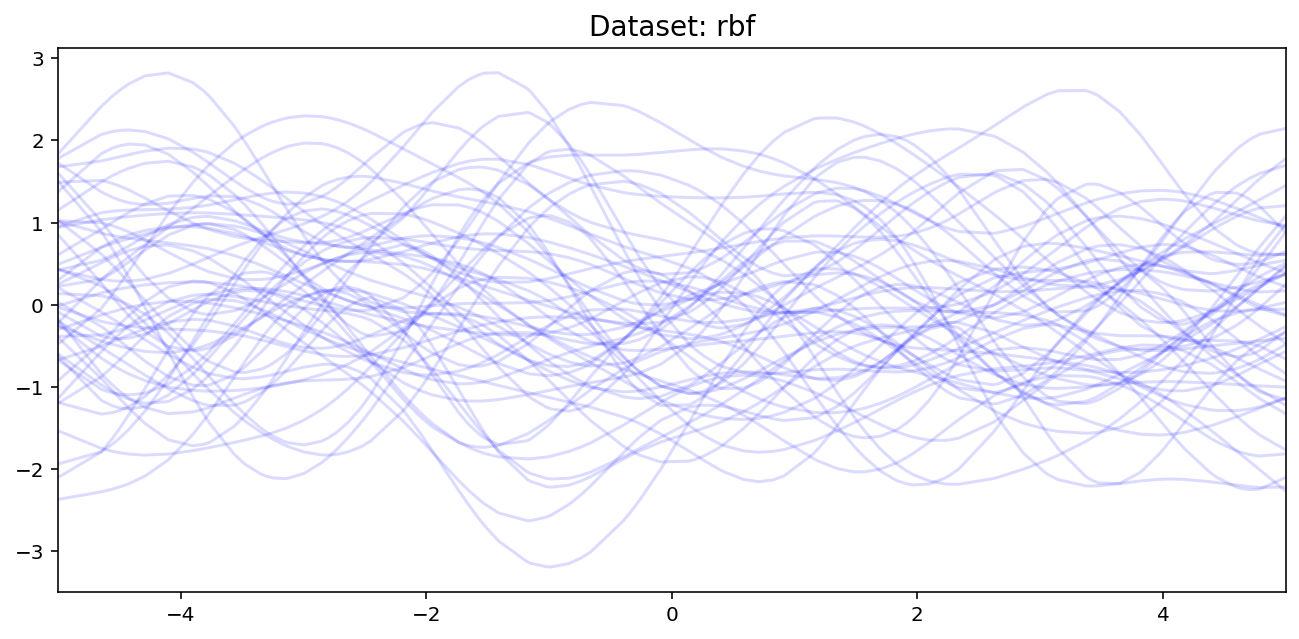

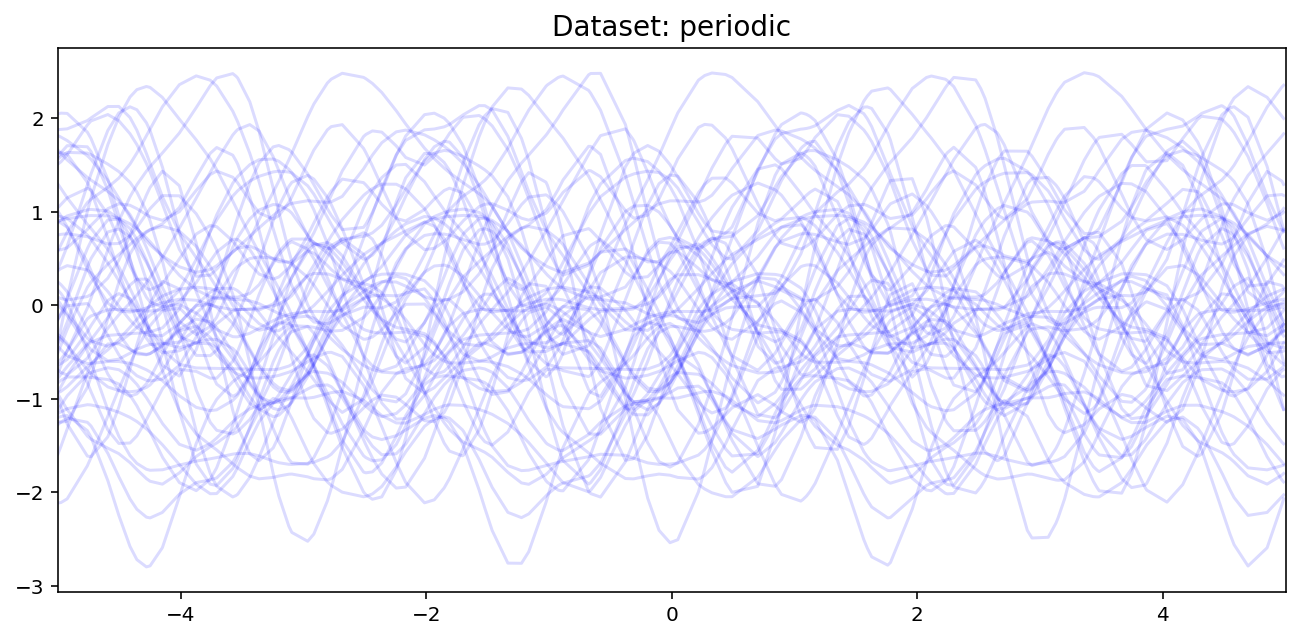

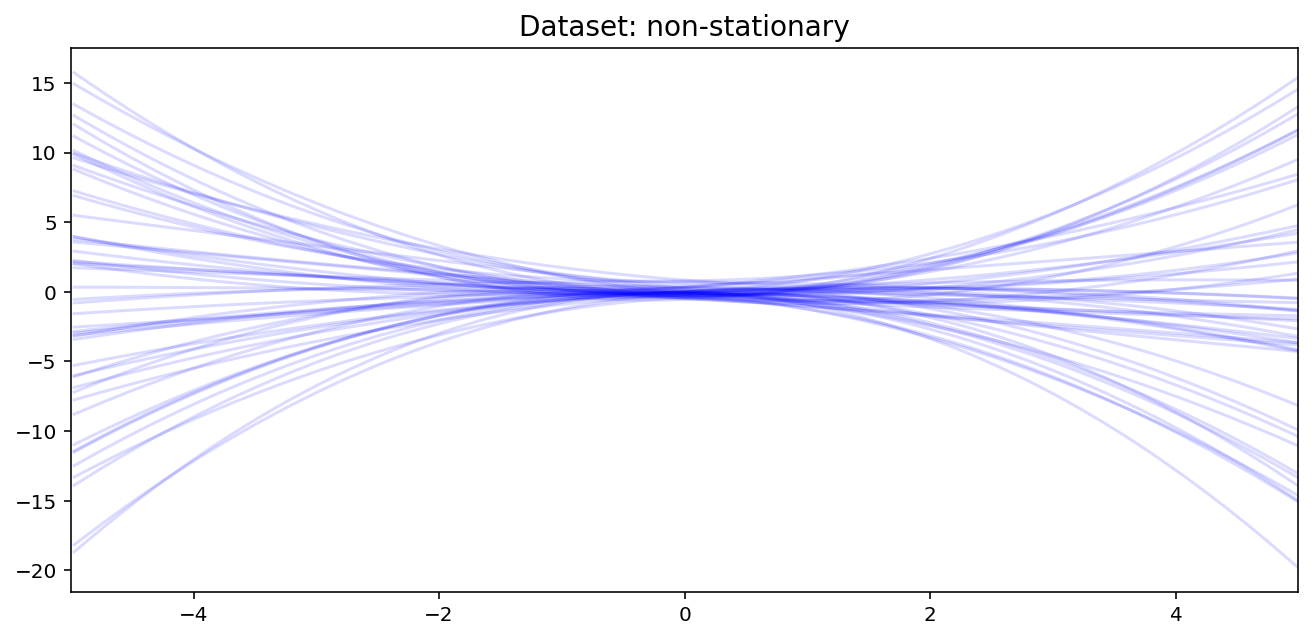

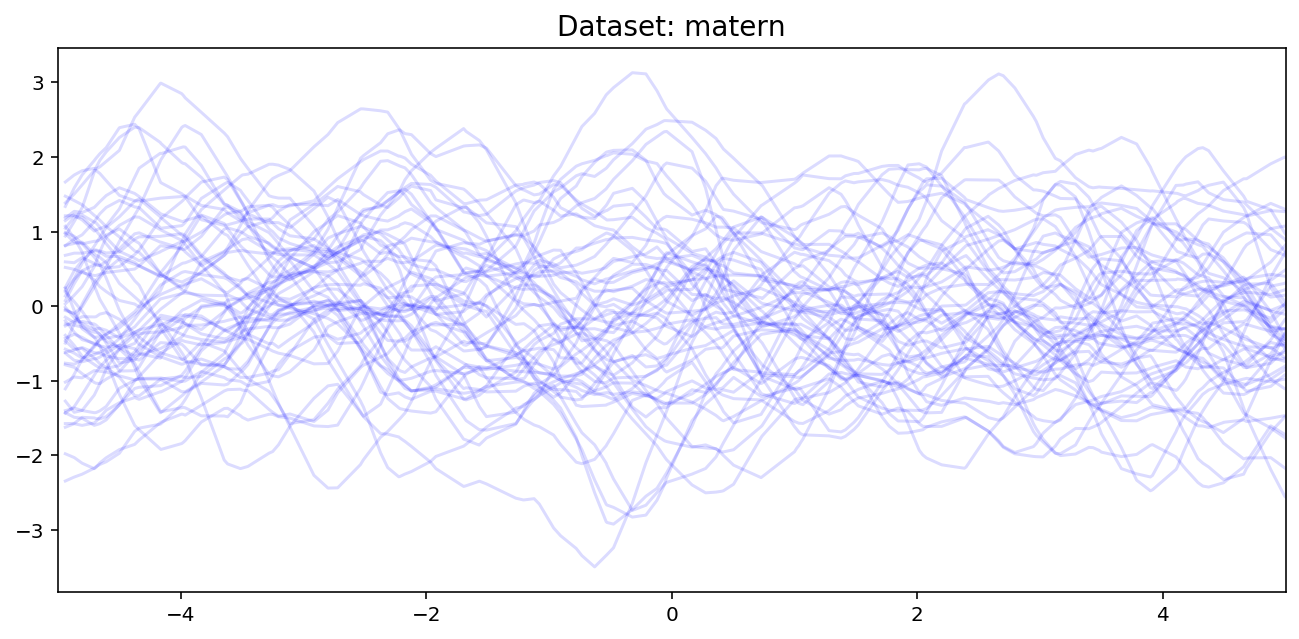

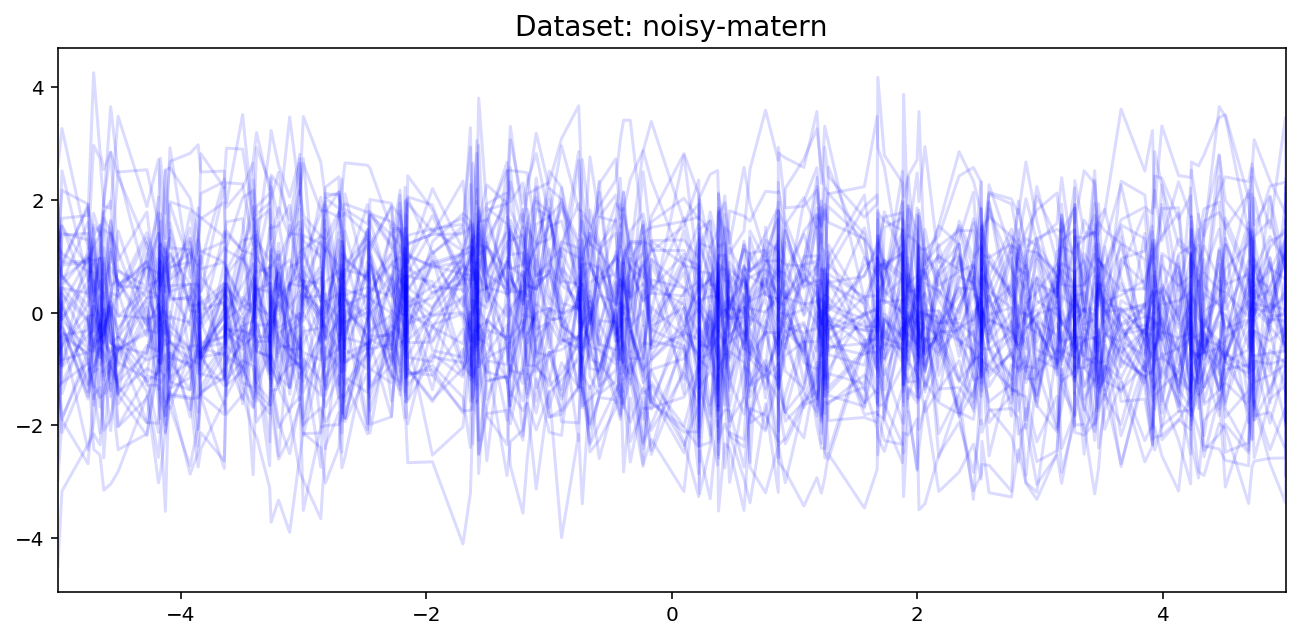

In [7]:
for k, dataset in datasets.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Model

The general model architecture is slightly different from the paper to make it modular and easy to extend, but it is easy to make them equivalent with the right parameters. See the docstrings of `NeuralProcess` for more details.

Plot of CNP / NP / ANP, note that all the yellow modules on the right corresponds to the yellow module on the left `*`. $\oplus$ represents a commutative operation (called `aggregator` in the code), typically a `mean` operation.

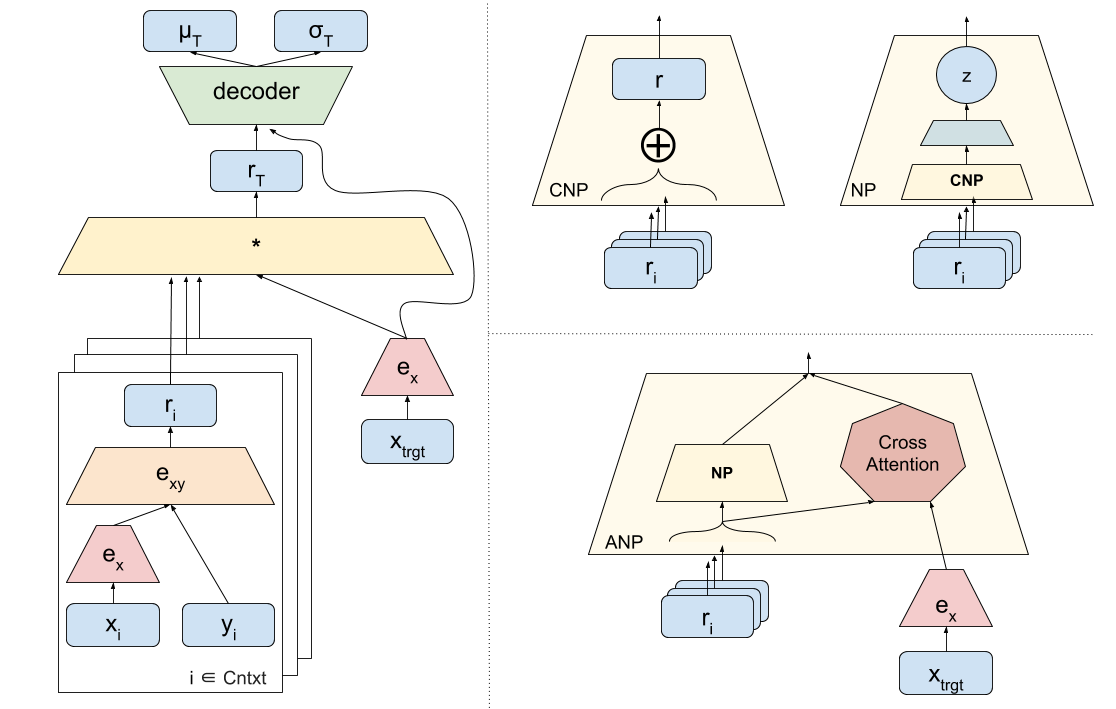

In [8]:
from IPython.display import Image
Image(filename='imgs/general_neural_process.png')

 Nota Bene: Although hyperparameters have been tested I haven't ran any hyperparameter optimization yet. 

**Main Parameters : Conditional Neural Process**
- `r_dim` : Dimension of hidden representation.
- `XEncoder` : Spatial encoder module which maps $\{x^{(i)}\} \to \{x_{transformed}^{(i)}\}$. Example:
    - `MLP` : will learn positional embeddings with MLP
    - `SinusoidalEncodings` : use sinusoidal positional encodings.
    - `Identity` : this is what they use in the paper but it doesn't work as well (less parameter sharing)
- `XYEncoder` : Encoder module which maps $\{x_{transformed}^{(i)}, y^{(i)}\} \to \{r^{(i)}\}$. Example:
    - `merge_flat_input(MLP, is_sum_merge=False)` : learn representation with MLP. `merge_flat_input` concatenates (or sums) X and Y inputs.
    - `SelfAttentionBlock` : self attention mechanisms (as [Attentive Neural Process]). For more parameters (attention type, number of layers ...) refer to its docstrings.
- `Decoder` : Decoder module which maps $\{r, x^{(*)}\} \to \{\hat{y}^{(*)}\}$. Example:
    - `add_flat_input(MLP)` : predict with MLP.
    - `SelfAttentionBlock` : predict with self attention mechanisms to have coherant predictions (not use in attentive neural process [Attentive Neural Process], but in [Image Transformer]). 
- `aggregator` : Agregreator function which maps $\{r_i\} \to r$. To use a cross attention aggregation, use `AttentiveNeuralProcess` instead of `NeuralProcess`.
- `get_cntxt_trgt` :  Function that split the input into context and target points. The splitting is done is done in the forward call to make easy to use with standard deep learning frameworks and datasets. Possible values:
    - `CntxtTrgtGetter()` does the target and context splitting for you based on indices. How to select the indices can easily be modified by parameters (by default random subset for context and all targets). When using this class you can also directly pass predefined context and target indices to the `forward` call. More details in the docstrings.
    - `GridCntxtTrgtGetter()` split grids of values (e.g. images) into context and target points. How to select the indices can easily be modified by parameters (random subsets, half grids, ...). When using this class you can also directly pass predefined context and target masks to the `forward` call. More details in the docstrings.
    - your own callable function, such that `X_cntxt, Y_cntxt, X_trgt, Y_trgt = get_cntxt_trgt(X, y, **kwargs)`, for example if you already have the context and target point, put them in a dictionary and split the dictionary in `get_cntxt_trgt`.
- `PredictiveDistribution` : Predictive distribution, e.g. `Normal`, `Laplace`, ...


**Additional Parameters : (Attentive) Neural Process**

- `encoded_path` : Which path(s) to use:
    - `"deterministic"` uses a [Conditional Neural Process] (no latents), where the decoder gets a deterministic representation as input (function of the context). 
    - `"latent"` uses a [Neural Process], where the decoder gets a sample latent representation as input (function of the target during training and context during test).
    - If `"both"` concatenates both representations as described in [Attentive Neural Process].
- `LatentEncoder` : Encoder which maps $r \to [\mu_z; f(\sigma_z)]$. Only used if `encoded_path` in `["latent", "both"]`.

To use cross-attention instead of aggregation (i.e. [Attentive Neural Process]) replace `NeuralProcess` with `AttentiveNeuralProcess`. Many different attention mechanisms are available (image transformer, multihead, dot head, manhattan ...), see its docstrings for more details. 
    

**Extensions**

- For Neural Process, see the [Tutorial 2 - Neural Process] notebook.
- For Attentive Neural Process, see the [Tutorial 3 - Attentive Neural Process] notebook.
- Bayesian Hyperparameter Optimization is easy to run as the library is a wrapper around sklearn. To do so use `BayesSearchCV` from [skopt](https://scikit-optimize.github.io) which is in *requirements.txt* ([example](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html))

[Neural Process]: https://arxiv.org/abs/1807.01622
[Conditional Neural Process]: https://arxiv.org/pdf/1807.01613.pdf
[Attentive Neural Process]: https://arxiv.org/abs/1901.05761
[Image Transformer]: https://arxiv.org/abs/1802.05751
[Tutorial 2 - Neural Process]: Tutorial%202%20-%20Neural%20Process.ipynb
[Tutorial 3 - Attentive Neural Process]: Tutorial%203%20-%20Attentive%20Neural%20Process.ipynb

In [9]:
from torch.distributions import Normal

from neuralproc import NeuralProcessLoss, NeuralProcess, merge_flat_input, get_uninitialized_mlp
from neuralproc.utils.datasplit import CntxtTrgtGetter, GetRandomIndcs, get_all_indcs

Let's define the context and target splitter, both the target and context points will be sampled uniformly in $[4,50]$, and the context points will be added to the target ones, as this has been show to be better.

In [10]:
get_cntxt_trgt = CntxtTrgtGetter(contexts_getter=GetRandomIndcs(min_n_indcs=4,  max_n_indcs=50), 
                                 targets_getter=GetRandomIndcs(min_n_indcs=4, max_n_indcs=50),
                                 is_add_cntxts_to_trgts=True) # add all context points to tagrtes

let's define the model for every datasets

In [11]:
def init_model():
    return NeuralProcess(X_DIM, Y_DIM,
                         get_cntxt_trgt=get_cntxt_trgt,
                         aggregator=torch.mean,
                         XEncoder=get_uninitialized_mlp(n_hidden_layers=1), # share X encoding (not done in the paper) 
                         XYEncoder=merge_flat_input(get_uninitialized_mlp(n_hidden_layers=2),
                                                    is_sum_merge=True),  # sum the encoded X and Y 
                         Decoder=merge_flat_input(get_uninitialized_mlp(n_hidden_layers=4),
                                                  is_sum_merge=True),  # sum the encoded X and Y 
                         r_dim=128,  
                         PredictiveDistribution=Normal, # Gaussian predictive distribution
                         encoded_path="deterministic") # use CNP

In [12]:
# initialize one model for each dataset
data_models = {name: (init_model(), data) 
               for name, data in datasets.items()}

/Users/yanndubois/Desktop/GitHub/Neural-Process-Family/neuralproc/utils/torchextend.py:53: UserWarning: hidden_size=32 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


### N Param

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [13]:
from utils.helpers import count_parameters

In [14]:
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break

N Param: 98498


### Prior Samples
We can visualize the prior (i.e. the output of the neural process without any context points) before training.

std: 2.3489632821083073


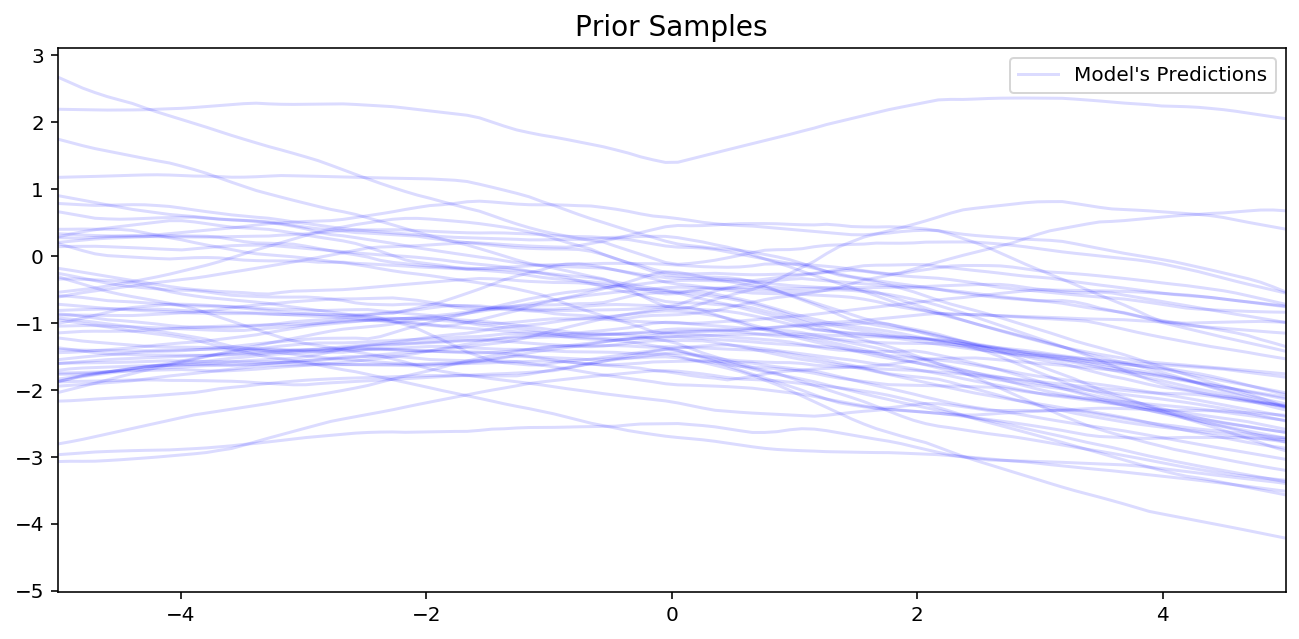

In [15]:
for k, (neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, train_min_max=dataset.min_max)
    # all the models at the start are "similar" so plot only one
    break

# Training

Training is handled by [skorch](https://github.com/skorch-dev/skorch), which is a sklearn-style wrapper around pytorch. 

**Highltights**
- sklearn-style wrapper around pytorch. this is especially handy for downstream tasks to make a pipeline which does a task after being represented (i.e. transformed in sklearn jargon) by a CNP.
- many nice callbacks (including best model checkpoint used below)
- you can interrupt training and run again a cell: it will start where it last stoped


In [16]:
from torch.optim import Adam
from skorch.callbacks import ProgressBar, Checkpoint
from skorch import NeuralNet
from utils.helpers import get_only_first_item

In [17]:
is_RETRAIN = True # if false load precomputed

In [ ]:
for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- {} {} ---".format("Training" if is_RETRAIN else "Loading", k))
    print()
    
    chckpt = Checkpoint(dirname="results/notebooks/neural_process/cnp_{}".format(k), 
                        monitor='train_loss_best') # train would be same as validation as always resamples
    
    model = NeuralNet(neural_proc, NeuralProcessLoss,
                      iterator_train__shuffle=True, # shuffle iterator
                      train_split=None,  # don't use cross validation dev set
                      warm_start=True, # continue training if stop and restart
                      device="cuda" if torch.cuda.is_available() else "cpu",
                      optimizer=Adam,
                      max_epochs=50, 
                      batch_size=64,
                      lr=1e-3, # they use 5e-5 because 16 batch size but that would be slow
                      callbacks=[ProgressBar(), chckpt]) 
    
    if is_RETRAIN:
        # give both X and y to `forward`
        _=model.fit({'X': get_only_first_item(dataset), "y": dataset.targets})

    # load in all case => even when training loads the best checkpoint
    model.initialize()
    model.load_params(checkpoint=chckpt)


--- Training rbf ---



  epoch    train_loss    cp      dur
-------  ------------  ----  -------
      1       55.6317     +  20.9360


      2       43.0912     +  23.4033


# Inference

## Trained Prior

The prior should now encode some information about the shapes of the functions. Neural processes can be thought of methods that learn a kernel functions from the data, if they are effective teh trained prior should thus be very similar to the the samples the datasets previously seen.

In [ ]:
EXTRAP_DISTANCE = 2  # add 2 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

In [ ]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, 
                       title="Trained Prior Samples : {}".format(k), 
                       test_min_max=EXTRAPOLATION_RANGE, 
                       train_min_max=INTERPOLATION_RANGE)

We see that the trained priors are not too bad but cannot learn very smooth samples (e.g. for all besides Matern).

## Posterior

Let us now investigate the posterior over functions when conditioned on some new context points.

In [ ]:
N_CNTXT = 10
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

To have a better understanding of uncertainty let's look at only 2 context points:

In [ ]:
N_CNTXT = 2
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

What about 20:

In [ ]:
N_CNTXT = 20
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=3*N_POINTS,
                           n_samples=1,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

We see that the predictions are not too bad.

**Good**:
- The standard devation does not collapse to the minimum value it can output (i.e. 0.1). 
- It is also relatively uncertain far from context points. This is even more true when extrapolating

**Bad**:
- it often underfits and the mean does not often pass through the context points (and the variance doesn't decrease at those points).
- periodicity pattern is not really periodic, which becomes clear when extrapolating